In [1]:
from fmm import Network,NetworkGraph,FastMapMatch,FastMapMatchConfig,UBODT
import pandas as pd
from shapely.wkt import loads
from shapely.geometry import LineString
import tracers as tr
import numpy as np
import os
import json
import statistics

#load network data and graph 
network = Network("../osmnx_example/rome/edges.shp","fid", "u", "v")
print("Nodes {} edges {}".format(network.get_node_count(),network.get_edge_count()))
graph = NetworkGraph(network)

[2025-03-12 16:41:27.074] [info] [network.cpp:72] Read network from file ../osmnx_example/rome/edges.shp
Nodes 142626 edges 338130
[2025-03-12 16:41:30.226] [info] [network.cpp:172] Number of edges 338130 nodes 142626
[2025-03-12 16:41:30.226] [info] [network.cpp:173] Field index: id 20 source 0 target 1
[2025-03-12 16:41:30.549] [info] [network.cpp:176] Read network done.
[2025-03-12 16:41:30.550] [info] [network_graph.cpp:17] Construct graph from network edges start
[2025-03-12 16:41:30.590] [info] [network_graph.cpp:30] Graph nodes 142626 edges 338130
[2025-03-12 16:41:30.590] [info] [network_graph.cpp:31] Construct graph from network edges end


In [2]:
ubodt = UBODT.read_ubodt_csv("../osmnx_example/rome/ubodt.txt")

[2025-03-12 16:41:43.077] [info] [ubodt.cpp:208] Reading UBODT file (CSV format) from ../osmnx_example/rome/ubodt.txt
[2025-03-12 16:41:44.040] [info] [ubodt.cpp:236] Read rows 1000000
[2025-03-12 16:41:44.946] [info] [ubodt.cpp:236] Read rows 2000000
[2025-03-12 16:41:45.816] [info] [ubodt.cpp:236] Read rows 3000000
[2025-03-12 16:41:46.752] [info] [ubodt.cpp:236] Read rows 4000000
[2025-03-12 16:41:47.651] [info] [ubodt.cpp:236] Read rows 5000000
[2025-03-12 16:41:48.645] [info] [ubodt.cpp:236] Read rows 6000000
[2025-03-12 16:41:49.506] [info] [ubodt.cpp:236] Read rows 7000000
[2025-03-12 16:41:50.352] [info] [ubodt.cpp:236] Read rows 8000000
[2025-03-12 16:41:51.249] [info] [ubodt.cpp:236] Read rows 9000000
[2025-03-12 16:41:52.120] [info] [ubodt.cpp:236] Read rows 10000000
[2025-03-12 16:41:52.946] [info] [ubodt.cpp:236] Read rows 11000000
[2025-03-12 16:41:53.789] [info] [ubodt.cpp:236] Read rows 12000000
[2025-03-12 16:41:54.654] [info] [ubodt.cpp:236] Read rows 13000000
[2025-0

In [ ]:
with open('datapath.json', 'r') as f:
    data = json.load(f)

root_path = data['data_path']

# these users wont give an empty mm result for the last 2000 points
valid_users_list = [4, 21, 24, 44, 70, 120, 144, 145, 153, 156, 167, 173, 183, 200, 201, 205, 220, 233, 245, 250, 264, 275, 283, 304, 306, 317, 353, 363, 371]

total_precision = []
total_recall = []
total_f1 = []
total_accuracy = []
ep_list = []
error_list = []
valid_users = 0

for user_id in valid_users_list:
    user_path = f'{user_id}.csv'
    file_path = os.path.join(root_path, user_path)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, sep=",")
        df = df.rename(columns={"ID": "id", "Latitude": "x", "Longitude": "y", "Timestamp": "timestamp"})

        # Convert timestamp to epoch and sort by timestamp
        df["timestamp"] = pd.to_datetime(df["timestamp"], format="ISO8601", errors="coerce").astype(int) / 10**9
        df["timestamp"] = df["timestamp"].astype(int)
        df = df.sort_values(by="timestamp")

        # Limit to first 2000 points 
        df = df.iloc[:1000]

        # Create wkt from lat lon data
        original_linestring = LineString(zip(df["y"], df["x"]))
        original_wkt = original_linestring.wkt
        model = FastMapMatch(network, graph, ubodt)

        # Configuration params
        k = 30
        radius = 400 / 100_000
        gps_error = 10 / 100_000

        fmm_config = FastMapMatchConfig(k, radius, gps_error, perturbation=False, reverse_tolerance=10)

        # mm on the original trajectory 
        result = model.match_wkt(original_wkt, fmm_config)

        if result.cpath: 
            print(f"Map matching succeeded for user {user_id}") 
            gt = loads(result.mgeom.export_wkt())  

            # Apply perturbation
            (space_noise, time_min_period) = (70.0, 30)
            trace = df[['y', 'x', 'timestamp']].to_numpy()
            trace = [tuple(x) for x in trace]
            trace = [(x[0], x[1], int(x[2])) for x in trace]

            perturbed_traces = tr.perturb_traces((space_noise, time_min_period), [trace], picker_str='closest')
            perturbed_trace = perturbed_traces[0]

            df_pert = pd.DataFrame(perturbed_trace, columns=["y", "x", "timestamp"])
            df_pert["id"] = df["id"].iloc[0]

            perturbed_linestring = LineString(zip(df_pert["y"], df_pert["x"]))
            perturbed_wkt = perturbed_linestring.wkt

            obfuscation_stdev = 10 / 100_000

            fmm_config_pert = FastMapMatchConfig(k, radius, obfuscation_stdev, perturbation=True, reverse_tolerance=10)
            result_pert = model.match_wkt(perturbed_wkt, fmm_config_pert)

            if result_pert.cpath: 
                perturbed_geom = loads(result_pert.mgeom.export_wkt())

                # Calculate intersection length between GT and perturbed matched result
                intersection = gt.intersection(perturbed_geom).length
                gt_length = gt.length
                mm_length = perturbed_geom.length

                # Calculate precision, recall, and F1 score
                precision = intersection / mm_length 
                recall = intersection / gt_length 
                f1 = (2 * precision * recall) / (precision + recall)
                accuracy = intersection/max(mm_length,gt_length)

                print(f"user {user_id}, F1: {f1}")
                total_precision.append(precision)
                total_recall.append(recall)
                total_f1.append(f1)
                total_accuracy.append(accuracy)

                candidates = result_pert.candidates
                for candidate in candidates:
                    ep_list.append(candidate.ep)
                    error_list.append(candidate.error)

                valid_users += 1

# precision, recall and f1
if valid_users > 0:
    med_precision = statistics.median(total_precision)  
    med_recall = statistics.median(total_recall)        
    med_f1 = statistics.median(total_f1)
    med_accuracy =  statistics.median(total_accuracy)               
    print(f"Valid users: {valid_users}")
    print(f"Median Precision: {med_precision}")
    print(f"Median Recall: {med_recall}")
    print(f"Median F1 Score: {med_f1}")
    print(f"Median Accuracy: {med_accuracy}")
else:
    print("map matching failed for all users")

Map matching succeeded for user 4
[2025-03-12 15:32:23.316] [warning] [fmm_algorithm.cpp:290] Traj 0 unmatched as point 212 and 213 not connected
[2025-03-12 15:32:24.757] [warning] [fmm_algorithm.cpp:290] Traj 0 unmatched as point 17 and 18 not connected
[2025-03-12 15:32:25.913] [warning] [fmm_algorithm.cpp:290] Traj 0 unmatched as point 172 and 173 not connected
Map matching succeeded for user 44
[2025-03-12 15:32:27.495] [warning] [fmm_algorithm.cpp:290] Traj 0 unmatched as point 355 and 356 not connected
[2025-03-12 15:32:28.555] [warning] [fmm_algorithm.cpp:290] Traj 0 unmatched as point 120 and 121 not connected
[2025-03-12 15:32:29.448] [warning] [fmm_algorithm.cpp:290] Traj 0 unmatched as point 517 and 518 not connected
[2025-03-12 15:32:30.174] [warning] [fmm_algorithm.cpp:290] Traj 0 unmatched as point 259 and 260 not connected
[2025-03-12 15:32:31.063] [warning] [fmm_algorithm.cpp:290] Traj 0 unmatched as point 356 and 357 not connected
[2025-03-12 15:32:33.168] [warning] [

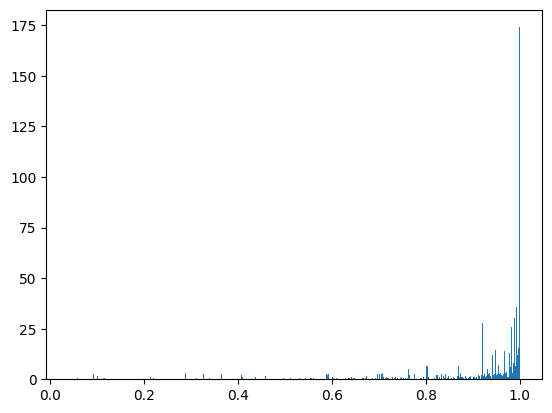

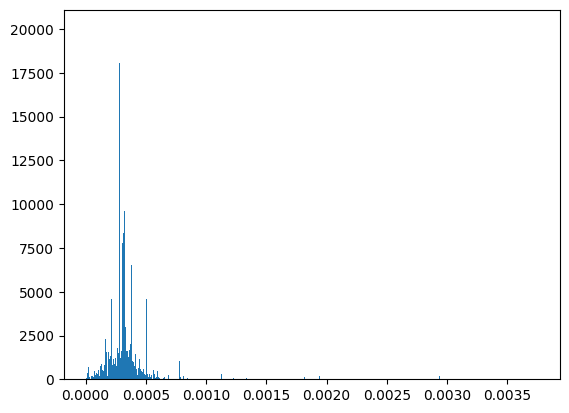

In [6]:
from matplotlib import pyplot as plt
plt.hist(ep_list,bins=5000,density=True)
plt.show()

plt.hist(error_list,bins=5000,density=True)
plt.show()

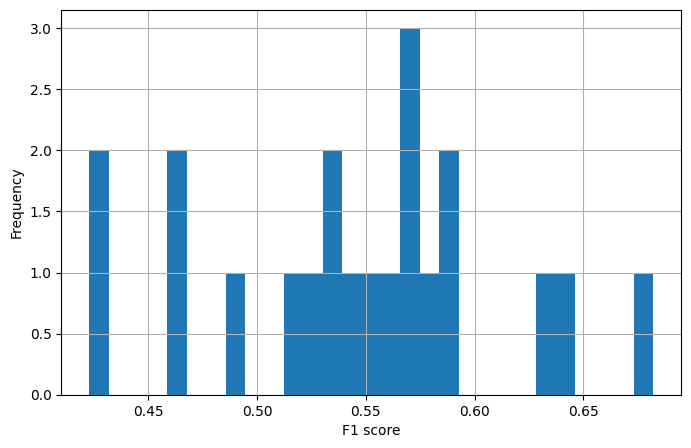

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(total_f1, bins=29)
plt.xlabel("Distribution of F1 scores of different users")  
plt.grid()
plt.ylabel("Frequency")
plt.xlabel("F1 score")
plt.show()